In [57]:
import matplotlib.pyplot as plt
import estimation_methods as est
import numpy as np
from tqdm import tqdm

np.random.seed(1)

In [58]:
plt.rcParams["figure.figsize"] = (8, 8)
# rng = np.random.default_rng(seed=42)

# Testing using synthetic systems

To compare our adaptive filters, we can generate synthetic systems that incorporate various types of perturbations and that feature varying levels of overdeterminedness. 

### Model setup

Consider an arbitrary multivariate signal and its measurement. We denote the system as:

$$\theta_{k+1}=f(x_k,u_k;\theta_k)+v_k$$

and the measurement as:

$$\hat{x}_{k+1}=h(x_k,u_k;\theta_{k})+w_k$$

where $\theta_k\in\mathbb{R}^n$, $x_k\in\mathbb{R}^m$, $v_k\sim\mathcal{N}(0, Q)$, and $w_k\sim\mathcal{N}(0, R)$. (Note: We use $\theta$ and $x$ because we are interested in parameter estimation whereas for state estimation you might use $x$ in the system and $y$ in the measurement.)

Then, we linearize the measurement model with respect to previous parameters $\hat{\theta}_{k-1}$ using a first-order approximation:

$$\hat{x}_{k+1}\approx f(x_k,u_k;\hat{\theta}_{k-1})+\left.\frac{\partial f}{\partial\theta}\right\vert_{\hat{\theta}_{k-1}}(\theta_k-\hat{\theta}_{k-1})+w_k$$

Then, if we let

$$A_k=\left.\frac{\partial f}{\partial\theta}\right\vert_{\hat{\theta}_{k-1}},\quad b_k=\hat{x}_{k+1}-f(x_k,u_k;\hat{\theta}_{k-1})+A_k\hat{\theta}_{k-1}-w_k$$

we can rewrite the linearized measurement form as:

$$A_k\theta_k=b_k.$$


### Adaptive filters

For RLS and DEKA adaptive filters, we can directly estimate the parameters given an initial estimate, the Jacobian of the measurement model with respect to the previous parameter estimate, and the actual measurement. For EKF, however, we must also consider the noise covariance matrices and system model Jacobian. As we do not know a priori what will occur to the system, we assume that the Jacobian of the system is:

$$F_k=\left.\frac{\partial f}{\partial\theta}\right\vert_{\hat{\theta}_{k-1}}=I_n.$$

Similarly, we assume that both system and measurement noise is time invariant. Thus:

$$Q_k=c_1I_n,\quad R_k=c_2I_m$$

for some $c_1\in\mathbb{R}^n$ and $c_2\in\mathbb{R}^m$. This reduces the predicted covariance update step in EKF to:

$$P_{k|k-1}=F_kP_{k-1|k-1}F_k^\mathsf{T}+Q_{k-1}=P_{k-1}+Q_{k-1}$$

For the remaining EKF steps, see the [Wikipedia page](https://en.wikipedia.org/wiki/Extended_Kalman_filter).


### Simulating on synthetic systems

We are interested in not only Gaussian noise but also arbitrary (sudden and gradual) scalings of the parameters. The latter case is of particular interest as we want to simulate how parameters may change in real-life scenarios like if a quadrotor were to pick up a large payload. Traditional adaptive filters should be able to handle these situations but they do not make use of particular inductive biases such as near-overdeterminedness of real-life systems.

To this end, we consider an arbitrary state space model:

$$\theta_{k+1}=\theta_k+v_k$$
$$\hat{x}_{k+1}=F_k\theta_k+w_k$$

## Ablation 1: RK vs DeKA (no smoothing) - low noise (compare average number of iterations)

deka_0: 2.9282049449753613e-07
rk: 7.438254501338213e-08
gt: 0


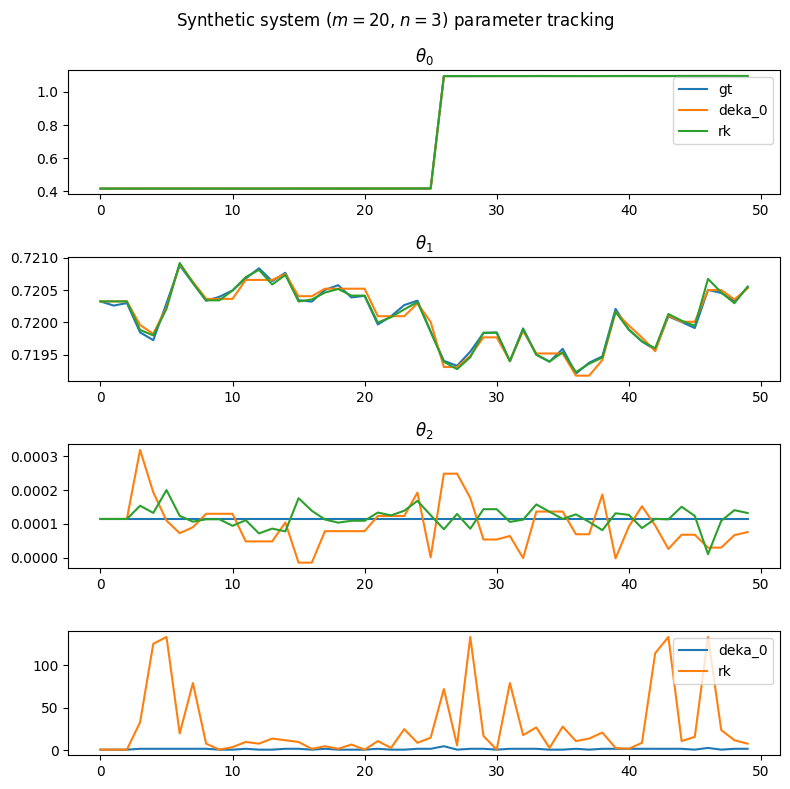

In [59]:
# simulation parameters
d = 20
p = 3

theta_true = np.random.rand(p, 1)
# theta_true = np.array([0.035, 1e-7, 1e-6]).reshape(-1, 1)
# noise is [0, 5]% about 95% of the time
process_noise_var = (0.05 * theta_true / 2) ** 2
# theta_true = np.random.uniform(3, 5, (p, 1)) # random parameters

filters = {
    # 'ekf': est.EKF(p, np.diag(np.random.normal(0, 0.05, p)), np.diag(np.random.normal(0, 0.01, d))),
    # 'rls_0.1': est.RLS(p, theta_hat=theta_true.copy(), forgetting_factor=0.1),
    # 'arls': est.AdaptiveLambdaRLS(p, forgetting_factor=0.7, alpha=0.1),
    # 'deka_0.9': est.DEKA(p, x0=theta_true.copy(), damping=0.1, regularization=1e-6, smoothing_factor=0.9),
    'deka_0': est.DEKA(p, x0=theta_true.copy(), damping=1, regularization=1e-6, smoothing_factor=0),
    # 'deka_0.5': est.DEKA(p, x0=theta_true.copy(), damping=0.1, regularization=1e-6, smoothing_factor=0.5),
    'rk': est.RK(p, x0=theta_true.copy(), alpha=0.5),
}

estimates = {f: [[] for _ in range(p)] for f in filters.keys()}
iters = {f: [] for f in filters.keys()}
actual = []
mse = {f: [] for f in filters.keys()}

# simulate system
nsim = 50

for k in range(nsim):
    A_k = np.random.randn(d, p)  # random Jacobian (or basically linear transformation)
    b_k = A_k @ theta_true

    # noise is [0 - 1]% noise w.p. 95%
    measurement_noise_var = (0.01 * b_k / 2) ** 2
    b_k += np.array([np.random.normal(0, v) for v in measurement_noise_var]).reshape(-1, 1)

    for name, f in filters.items():
        if 'deka' in name:
            estimate, _, it = f.iterate(A_k, b_k, num_iterations=int(d ** 2 / p), tol=1e-3)
            iters[name].append(it)
        elif 'rk' in name:
            estimate, it = f.iterate(A_k, b_k, num_iterations=int(d ** 2 / p), tol=1e-3)
            iters[name].append(it)
        else:
            estimate = f.iterate(A_k, b_k)

        for i in range(p):
            estimates[name][i].append(estimate[i].item())
        
        mse[name].append(np.square(estimate - theta_true).mean())

    actual.append(theta_true.copy())

    # add perturbation
    # theta_true += np.random.normal(0, 0.001, (p, 1))
    theta_true += np.array([np.random.normal(0, v) for v in process_noise_var])

    # add major perturbation to parameter 0 only
    if k == 25:
        theta_true[0] *= np.random.uniform(0.25, 4)

# process data
mse['gt'] = [0 for _ in range(nsim)]
actual = np.array(actual).squeeze().T

# print total mse
for name, vals in mse.items():
    print(f"{name}: {np.sum(vals)}")

# plot results
nplots = p
fig, axs = plt.subplots(nplots + 1)

fig.suptitle(f"Synthetic system ($m={d}$, $n={p}$) parameter tracking")

for i in range(nplots):
    axs[i].plot(actual[i], label="gt")
    # axs[i].set_yscale("log")
    axs[i].set_title(f"$\\theta_{i}$")

for name, vals in estimates.items(): 
    for i in range(nplots):
        axs[i].plot(vals[i], label=name)

for name, it in iters.items():
    axs[nplots].plot(it, label=name)

axs[0].legend()
axs[nplots].legend()

fig.tight_layout()
plt.show()

In [60]:
d = 20
p = 3

nsim = 50
trials = 1000

filter_names = [
        'deka_0',
        'rk'
    ]

mse = {f: [] for f in filter_names}
non_pert_mse = {f: [] for f in filter_names}

# Create a dictionary to store iteration counts for each update.
iteration_counts = {f: [] for f in filter_names}

for t in tqdm(range(trials)):
    theta_true = np.random.rand(p, 1)
    # theta_true = np.array([0.035, 1e-7, 1e-6]).reshape(-1, 1)
    # noise is [0, 5]% about 95% of the time
    process_noise_var = (0.05 * theta_true / 2) ** 2
    # theta_true = np.random.uniform(3, 5, (p, 1)) # random parameters

    filters = {
        # 'ekf': est.EKF(p, np.diag(np.random.normal(0, 0.05, p)), np.diag(np.random.normal(0, 0.01, d))),
        # 'rls_0.1': est.RLS(p, theta_hat=theta_true.copy(), forgetting_factor=0.1),
        # 'arls': est.AdaptiveLambdaRLS(p, forgetting_factor=0.7, alpha=0.1),
        # 'deka_0.9': est.DEKA(p, x0=theta_true.copy(), damping=0.1, regularization=1e-6, smoothing_factor=0.9),
        'deka_0': est.DEKA(p, x0=theta_true.copy(), damping=1, regularization=1e-6, smoothing_factor=0),
        # 'deka_0.5': est.DEKA(p, x0=theta_true.copy(), damping=0.1, regularization=1e-6, smoothing_factor=0.5),
        'rk': est.RK(p, x0=theta_true.copy(), alpha=0.5),
    }

    trial_mse = {f: [] for f in filters}
    trial_non_pert_mse = {f: [] for f in filters}

    for k in range(nsim):
        A_k = np.random.randn(d, p)  # random Jacobian (or basically linear transformation)
        b_k = A_k @ theta_true

        # noise is [0 - 1]% noise w.p. 95%
        measurement_noise_var = (0.01 * b_k / 2) ** 2
        b_k += np.array([np.random.normal(0, v) for v in measurement_noise_var]).reshape(-1, 1)

        for name, f in filters.items():
            if 'deka' in name:
                estimate, _, it = f.iterate(A_k, b_k, num_iterations=int(d ** 2 / p), tol=1e-3)
            elif 'rk' in name:
                estimate, it = f.iterate(A_k, b_k, num_iterations=int(d ** 2 / p), tol=1e-3)
            else:
                estimate = f.iterate(A_k, b_k)
            
            iteration_counts[name].append(it)

            sq_res = np.square(estimate - theta_true)
            trial_mse[name].append(sq_res.mean())
            trial_non_pert_mse[name].append(sq_res[1:].mean())

        # add perturbation
        theta_true += np.array([np.random.normal(0, v) for v in process_noise_var])

        # add major perturbation to parameter 0 only
        if k == 25:
            theta_true[0] *= np.random.uniform(0.25, 4)
    
    for name, vals in trial_mse.items():
        mse[name].append(np.sum(vals))
    
    for name, vals in trial_non_pert_mse.items():
        non_pert_mse[name].append(np.sum(vals))


100%|██████████| 1000/1000 [01:52<00:00,  8.92it/s]


Parameter tracking MSE averages
deka_0: 5.907497269497442e-07
rk: 0.0007808431644270105
Non-perturbed parameter tracking MSE averages
deka_0: 5.130553404801001e-07
rk: 0.0004945793871334467
Iteration counts summary:
deka_0: avg iterations per update = 8.77232, std deviation = 29.018039248329654, total iterations = 438616


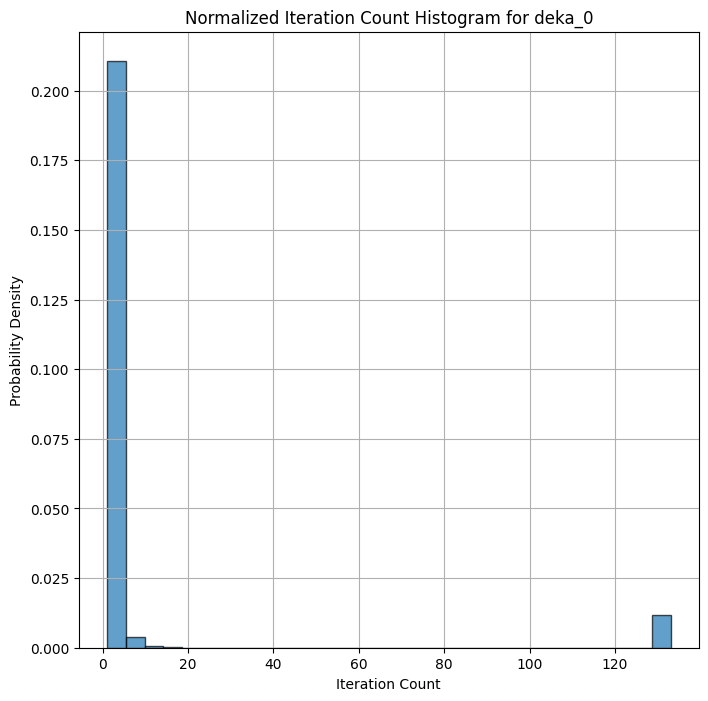

rk: avg iterations per update = 38.28152, std deviation = 49.26414016797208, total iterations = 1914076


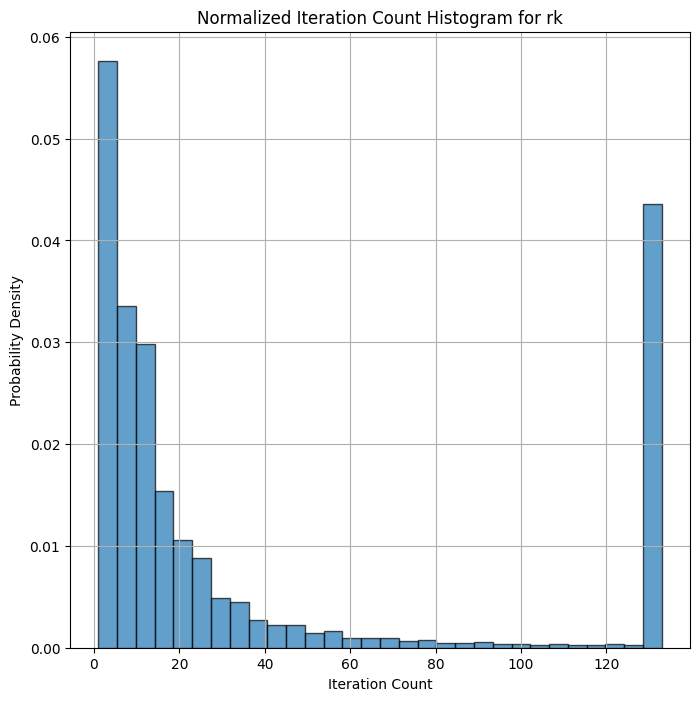

In [64]:
print("Parameter tracking MSE averages")
for name, vals in mse.items():
    print(f"{name}: {np.mean(vals)}")

print("Non-perturbed parameter tracking MSE averages")
for name, vals in non_pert_mse.items():
    print(f"{name}: {np.mean(vals)}")

print("Iteration counts summary:")
for name, iters in iteration_counts.items():
    avg_iters = np.mean(iters)
    std_iters = np.std(iters)
    total_iters = np.sum(iters)
    print(f"{name}: avg iterations per update = {avg_iters}, std deviation = {std_iters}, total iterations = {total_iters}")

    plt.figure()
    plt.hist(iters, bins=30, density=True, alpha=0.7, edgecolor='black')
    plt.title(f"Normalized Iteration Count Histogram for {name}")
    plt.xlabel("Iteration Count")
    plt.ylabel("Probability Density")
    plt.grid(True)
    plt.show()

## Ablation 2: GRK vs DeKA (smoothing) - high noise (compare MSE)

deka_0: 0.008525411942668247
deka_0.5: 0.0017549116702435033
deka_0.9: 0.0046925335255012576
gt: 0


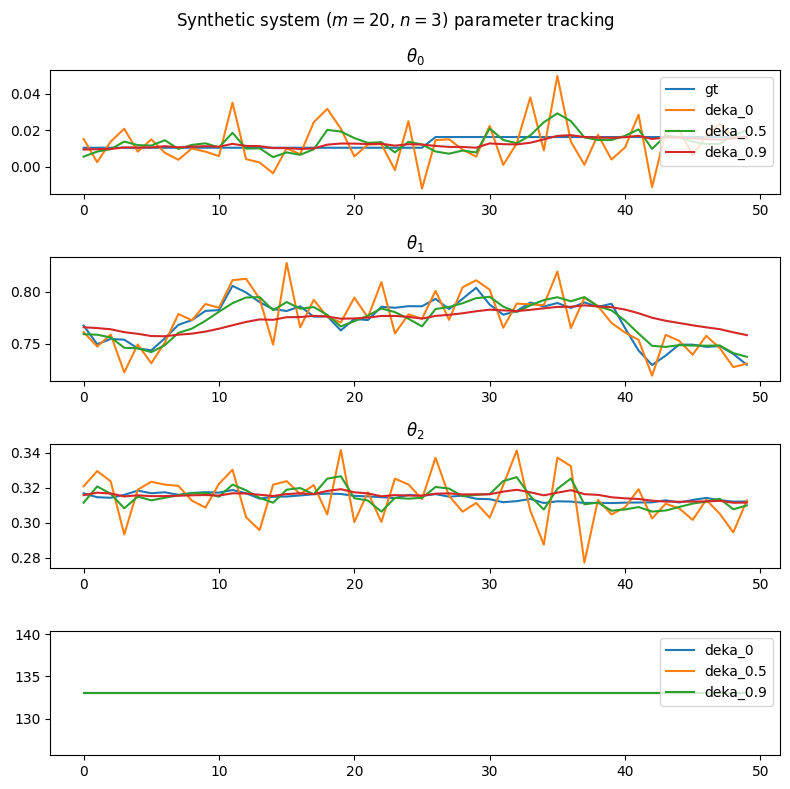

In [53]:
# simulation parameters
d = 20
p = 3

theta_true = np.random.rand(p, 1)
# theta_true = np.array([0.035, 1e-7, 1e-6]).reshape(-1, 1)
# noise is [0, 5]% about 95% of the time
process_noise_var = (0.25 * theta_true / 2) ** 2
# theta_true = np.random.uniform(3, 5, (p, 1)) # random parameters

filters = {
    # 'ekf': est.EKF(p, np.diag(np.random.normal(0, 0.05, p)), np.diag(np.random.normal(0, 0.01, d))),
    # 'rls_0.1': est.RLS(p, theta_hat=theta_true.copy(), forgetting_factor=0.1),
    # 'arls': est.AdaptiveLambdaRLS(p, forgetting_factor=0.7, alpha=0.1),
    'deka_0': est.DEKA(p, x0=theta_true.copy(), damping=1, regularization=1e-6, smoothing_factor=0),
    'deka_0.5': est.DEKA(p, x0=theta_true.copy(), damping=0.1, regularization=1e-6, smoothing_factor=0.5),
    'deka_0.9': est.DEKA(p, x0=theta_true.copy(), damping=0.1, regularization=1e-6, smoothing_factor=0.9),
    # 'rk': est.RK(p, x0=theta_true.copy(), alpha=0.5),
}

estimates = {f: [[] for _ in range(p)] for f in filters.keys()}
iters = {f: [] for f in filters.keys()}
actual = []
mse = {f: [] for f in filters.keys()}

# simulate system
nsim = 50

for k in range(nsim):
    A_k = np.random.randn(d, p)  # random Jacobian (or basically linear transformation)
    b_k = A_k @ theta_true

    # noise is [0 - 1]% noise w.p. 95%
    measurement_noise_var = (0.25 * b_k / 2) ** 2
    b_k += np.array([np.random.normal(0, v) for v in measurement_noise_var]).reshape(-1, 1)

    for name, f in filters.items():
        if 'deka' in name:
            estimate, _, it = f.iterate(A_k, b_k, num_iterations=int(d ** 2 / p), tol=1e-3)
            iters[name].append(it)
        elif 'rk' in name:
            estimate, it = f.iterate(A_k, b_k, num_iterations=int(d ** 2 / p), tol=1e-3)
            iters[name].append(it)
        else:
            estimate = f.iterate(A_k, b_k)

        for i in range(p):
            estimates[name][i].append(estimate[i].item())
        
        mse[name].append(np.square(estimate - theta_true).mean())

    actual.append(theta_true.copy())

    # add perturbation
    # theta_true += np.random.normal(0, 0.001, (p, 1))
    theta_true += np.array([np.random.normal(0, v) for v in process_noise_var])

    # add major perturbation to parameter 0 only
    if k == 25:
        theta_true[0] *= np.random.uniform(0.25, 4)

# process data
mse['gt'] = [0 for _ in range(nsim)]
actual = np.array(actual).squeeze().T

# print total mse
for name, vals in mse.items():
    print(f"{name}: {np.sum(vals)}")

# plot results
nplots = p
fig, axs = plt.subplots(nplots + 1)

fig.suptitle(f"Synthetic system ($m={d}$, $n={p}$) parameter tracking")

for i in range(nplots):
    axs[i].plot(actual[i], label="gt")
    # axs[i].set_yscale("log")
    axs[i].set_title(f"$\\theta_{i}$")

for name, vals in estimates.items(): 
    for i in range(nplots):
        axs[i].plot(vals[i], label=name)

for name, it in iters.items():
    axs[nplots].plot(it, label=name)

axs[0].legend()
axs[nplots].legend()

fig.tight_layout()
plt.show()

In [54]:
d = 20
p = 3

nsim = 50
trials = 1000

filters = [
    'deka_0',
    'deka_0.5',
    'deka_0.9',
]

mse = {f: [] for f in filters}
non_pert_mse = {f: [] for f in filters}

for t in tqdm(range(trials)):
    # noise is [0, 5]% about 95% of the time
    theta_true = np.random.rand(p, 1)
    # theta_true = np.array([0.035, 1e-7, 1e-6]).reshape(-1, 1)
    # noise is [0, 5]% about 95% of the time
    process_noise_var = (0.25 * theta_true / 2) ** 2
    # theta_true = np.random.uniform(3, 5, (p, 1)) # random parameters

    filters = {
        # 'ekf': est.EKF(p, np.diag(np.random.normal(0, 0.05, p)), np.diag(np.random.normal(0, 0.01, d))),
        # 'rls_0.1': est.RLS(p, theta_hat=theta_true.copy(), forgetting_factor=0.1),
        # 'arls': est.AdaptiveLambdaRLS(p, forgetting_factor=0.7, alpha=0.1),
        'deka_0': est.DEKA(p, x0=theta_true.copy(), damping=1, regularization=1e-6, smoothing_factor=0),
        'deka_0.5': est.DEKA(p, x0=theta_true.copy(), damping=0.1, regularization=1e-6, smoothing_factor=0.5),
        'deka_0.9': est.DEKA(p, x0=theta_true.copy(), damping=0.1, regularization=1e-6, smoothing_factor=0.9),
        # 'rk': est.RK(p, x0=theta_true.copy(), alpha=0.5),
    }

    trial_mse = {f: [] for f in filters}
    trial_non_pert_mse = {f: [] for f in filters}

    for k in range(nsim):
        A_k = np.random.randn(d, p)  # random Jacobian (or basically linear transformation)
        b_k = A_k @ theta_true

        # noise is [0 - 1]% noise w.p. 95%
        measurement_noise_var = (0.25 * b_k / 2) ** 2
        b_k += np.array([np.random.normal(0, v) for v in measurement_noise_var]).reshape(-1, 1)

        for name, f in filters.items():
            if 'deka' in name:
                estimate, _, it = f.iterate(A_k, b_k, num_iterations=int(d ** 2 / p), tol=1e-3)
            elif 'rk' in name:
                estimate, it = f.iterate(A_k, b_k, num_iterations=int(d ** 2 / p), tol=1e-3)
            else:
                estimate = f.iterate(A_k, b_k)
            
            sq_res = np.square(estimate - theta_true)
            trial_mse[name].append(sq_res.mean())
            trial_non_pert_mse[name].append(sq_res[1:].mean())

        # add perturbation
        theta_true += np.array([np.random.normal(0, v) for v in process_noise_var])

        # add major perturbation to parameter 0 only
        if k == 25:
            theta_true[0] *= np.random.uniform(0.25, 4)
    
    for name, vals in trial_mse.items():
        mse[name].append(np.sum(vals))
    
    for name, vals in trial_non_pert_mse.items():
        non_pert_mse[name].append(np.sum(vals))

100%|██████████| 1000/1000 [10:30<00:00,  1.59it/s]


In [55]:
print("Parameter tracking MSE averages")
for name, vals in mse.items():
    print(f"{name}: {np.mean(vals)}")

print("Non-perturbed parameter tracking MSE averages")
for name, vals in non_pert_mse.items():
    print(f"{name}: {np.mean(vals)}")

Parameter tracking MSE averages
deka_0: 0.21592840815188175
deka_0.5: 0.12498221803358879
deka_0.9: 1.2180007849635968
Non-perturbed parameter tracking MSE averages
deka_0: 0.1541211664482603
deka_0.5: 0.02914025565288166
deka_0.9: 0.013908448768475965


### testing over varying degrees of over-determinedness

Let $p=4$. We compute RMSE 

In [56]:
# p = 4
# dinit = p
# stop = 100

# nsim = 50
# trials = 10

# filters = [
#     'rls_0.1',
#     'deka_0.1'
# ]

# results = {f: [] for f in filters}

# for scale in range(1, stop + 1, 4):
#     d = dinit * scale

#     scale_mse = {f: [] for f in filters}

#     for t in range(trials):
#         # noise is [0, 5]% about 95% of the time
#         theta_true = np.random.rand(p, 1)
#         process_noise_var = (0.1 * theta_true / 2) ** 2

#         filters = {
#             # 'ekf': est.EKF(p, np.diag(np.random.normal(0, 0.005, p)), np.diag(np.random.normal(0, 0.005, d))),
#             'rls_0.1': est.RLS(p, theta_hat=theta_true.copy(), forgetting_factor=0.1),
#             # 'arls': est.AdaptiveLambdaRLS(p, forgetting_factor=0.7, alpha=0.1),
#             # 'deka_0.9': est.DEKA(p, x0=theta_true.copy(), damping=0.1, regularization=1e-6, smoothing_factor=0.9),
#             'deka_0.1': est.DEKA(p, x0=theta_true.copy(), damping=0.1, regularization=1e-6, smoothing_factor=0.1)
#         }

#         mse = {f: [] for f in filters}

#         for k in range(nsim):
#             A_k = np.random.randn(d, p)  # random Jacobian (or basically linear transformation)
#             b_k = A_k @ theta_true

#             # noise is [0 - 1]% noise w.p. 95%
#             # measurement_noise_var = (0.01 * b_k / 2) ** 2
#             # b_k += np.array([np.random.normal(0, v) for v in measurement_noise_var]).reshape(-1, 1)

#             for name, f in filters.items():
#                 if 'deka' in name:
#                     estimate = f.iterate(A_k, b_k, num_iterations=int(d ** 2 / p), tol=1e-4)
#                 else:
#                     estimate = f.iterate(A_k, b_k)
                
#                 mse[name].append(np.square(estimate - theta_true).mean())

#             # add perturbation
#             theta_true += np.array([np.random.normal(0, v) for v in process_noise_var])

#             # add major perturbation to parameter 0 only
#             if k == 25:
#                 theta_true[0] *= 2
        
#         for name, vals in mse.items():
#             scale_mse[name].append(np.sum(vals))
    
#     for name, vals in scale_mse.items():
#         results[name].append(np.sum(vals))

# fig, ax = plt.subplots()

# for name, vals in results.items():
#     ax.plot(range(1, stop + 1, 4), vals, label=name)

# ax.set_xscale("log")
# ax.set_xlabel("Degree of overdeterminedness (m / n)")
# ax.set_yscale("log")
# ax.legend()
# fig.tight_layout()
# plt.show()